In [1]:
import random

In [1]:
import json
def get_num_objects(path='./data/annotations/instances_val2017.json'):
    coco = json.load(open(path, 'r'))
    annot = coco['annotations']
    print(len(annot))

get_num_objects()
get_num_objects(path='./data/annotations/instances_train2017.json')

36781
860001


In [26]:
import os
import cv2
import json
import torch
from torch.utils.data import Dataset
from torchvision import tv_tensors

class COCODataset(Dataset):
    def __init__(self, image_dir, annot_path, transforms):
        self.image_dir = image_dir
        self.transforms = transforms

        with open(annot_path, 'r') as f:
            coco = json.load(f)

        self.image_id_to_file_name = {img["id"]: img["file_name"] for img in coco["images"]}

        self.image_id_to_annotations = {}
        for annot in coco["annotations"]:
            img_id = annot["image_id"]
            if img_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[img_id] = []
            self.image_id_to_annotations[img_id].append({
                "bbox": annot["bbox"],
                "category_id": annot["category_id"],
            })

        self.ids = list(self.image_id_to_file_name.keys())
        self.cat_id_to_label = {cat["id"]: idx for idx, cat in enumerate(coco["categories"])}
        # There are total 80 categories, apparently COCO dataset's category ids start from 1 to 90, with some gaps.

        del coco  # Free memory

    def __len__(self):
        return len(self.ids)

    def is_valid_box(self, box):
        return len(box) == 4 and all(i >=0 for i in box) and box[2] > 0 and box[3] > 0

    def __getitem__(self, index):
        img_id = self.ids[index]
        file_name = self.image_id_to_file_name[img_id]
        file_path = os.path.join(self.image_dir, file_name)

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        anns = self.image_id_to_annotations.get(img_id, [])

        boxes = []
        labels = []

        for ann in anns:
            if self.is_valid_box(ann["bbox"]):
                boxes.append(ann["bbox"])
                labels.append(self.cat_id_to_label[ann["category_id"]])

        boxes = tv_tensors.BoundingBoxes(boxes, format="XYWH", canvas_size=(image.shape[0], image.shape[1]))
        image, boxes = self.transforms(image, boxes)
        boxes = boxes.as_subclass(torch.Tensor)

        # Get image size after augmentation
        _, H, W = image.shape

        # Convert to [cx, cy, w, h] normalized
        boxes[:, 0] = (boxes[:, 0] + boxes[:, 2] / 2) / W  # cx
        boxes[:, 1] = (boxes[:, 1] + boxes[:, 3] / 2) / H  # cy
        boxes[:, 2] = boxes[:, 2] / W                      # w
        boxes[:, 3] = boxes[:, 3] / H                      # h

        target = {
            'boxes': boxes,
            'labels': torch.tensor(labels, dtype=torch.int64),
        }

        return image, target

In [64]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

def plot_coco_image(image, target, label_to_name=None):
    """
    Plot an image with normalized center-format (cx, cy, w, h) boxes and labels.
    
    Args:
        image (PIL.Image or Tensor): The input image (PIL or Tensor in [0, 1]).
        target (dict): A dictionary with 'boxes' (in cx, cy, w, h normalized format) and 'labels'.
        label_to_name (dict, optional): Maps label integers to human-readable names.
    """
    # Convert tensor image to PIL if needed
    if isinstance(image, torch.Tensor):
        image = F.to_pil_image(image)

    W, H = image.size  # width, height
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    boxes = target['boxes']
    labels = target['labels']

    for i in range(len(boxes)):
        cx, cy, w, h = boxes[i].tolist()

        # Convert normalized cx, cy, w, h to pixel x_min, y_min, w, h
        box_w = w * W
        box_h = h * H
        x_min = (cx * W) - (box_w / 2)
        y_min = (cy * H) - (box_h / 2)

        # Draw rectangle
        rect = patches.Rectangle((x_min, y_min), box_w, box_h,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Draw label
        label = labels[i].item()
        if label_to_name:
            text = label_to_name.get(label, str(label))
        else:
            text = str(label)

        ax.text(x_min, y_min - 5, text,
                fontsize=12, color='white',
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [28]:
def get_label_to_name(coco_annotations_file_path):
    file_dict = json.load(open(coco_annotations_file_path, 'r'))
    label_to_name = {i: cat_dict['name'] for i, cat_dict in enumerate(file_dict['categories'])}
    label_to_name[len(file_dict['categories'])] = 'background'  # Add 81 as background class
    return label_to_name

def get_label_to_coco_id(coco_annotations_file_path):
    file_dict = json.load(open(coco_annotations_file_path, 'r'))
    label_to_coco_id = {cat_dict['id']: i for i, cat_dict in enumerate(file_dict['categories'])}
    return label_to_coco_id

In [ ]:
from torchvision.transforms import v2

def get_train_transforms(size=640):
    return v2.Compose([
        v2.ToImage(),
        
        v2.RandomChoice([
            v2.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=10, fill=0, interpolation=v2.InterpolationMode.BILINEAR),
            v2.RandomPerspective(distortion_scale=0.5, p=0.3, fill=0, interpolation=v2.InterpolationMode.BILINEAR),
        ], [0.7, 0.3]),

        v2.RandomChoice([
            v2.Identity(),
            v2.RandomResizedCrop(size=(size, size), scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=v2.InterpolationMode.BILINEAR),
            v2.RandomCrop(size=(size, size), pad_if_needed=True, padding_mode='constant', fill=0),
        ], [0.4, 0.3, 0.3]),

        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.1),

        v2.RandomApply([v2.ColorJitter(brightness=0.5, contrast=0.5)], p=0.5),
        v2.RandomApply([v2.ColorJitter(saturation=0.5, hue=0.5)], p=0.2),

        v2.RandomApply([v2.GaussianBlur(kernel_size=13, sigma=(0.1, 5.0))], p=0.2),

        v2.Resize((size, size), interpolation=v2.InterpolationMode.BILINEAR),

        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

def get_val_transforms(size=640):
    return v2.Compose([
        v2.ToImage(),
        v2.Resize((size, size), interpolation=v2.InterpolationMode.BILINEAR),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])


In [85]:
dataset = COCODataset(
    image_dir='./data/val2017/',
    annot_path='./data/annotations/instances_val2017.json',
    transforms=get_val_transforms()
)

In [74]:
label_to_name = get_label_to_name('./data/annotations/instances_val2017.json')

Image shape: torch.Size([3, 640, 640])


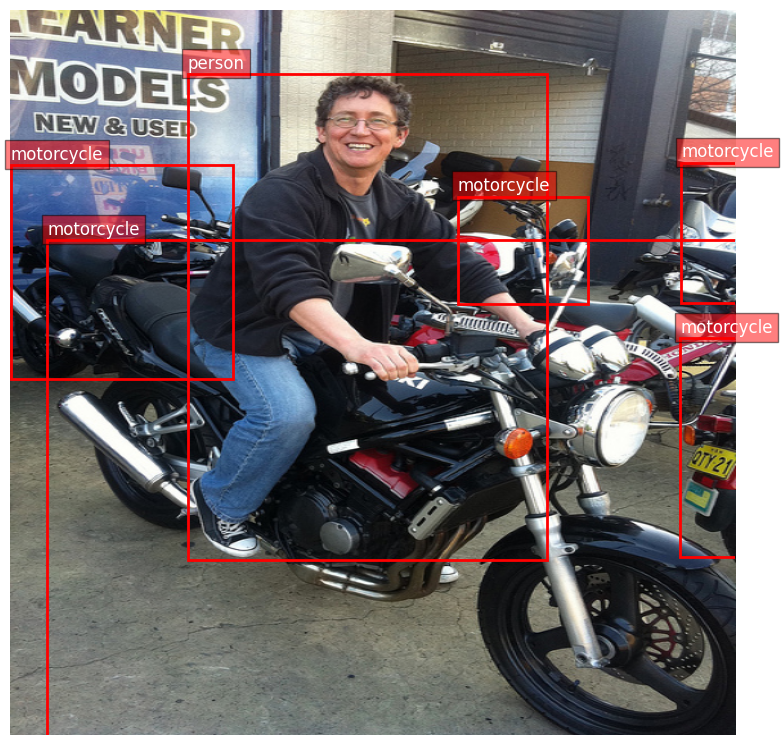

In [90]:
length = len(dataset)
idx = random.randint(0, length - 1)
image, targets = dataset[idx]
print(f"Image shape: {image.shape}")
plot_coco_image(image, targets, label_to_name)